In [1]:
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk import accuracy
from numpy.ma.core import argmax
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch import dtype
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from BayesianLLNN import BayesianLastLayer,PredLastLayer,TrainLastLayer,BaseNetwork,TrainLastLayerCL, PredLastLayerCl, BaseNetworkCL
from baseNN import GetNeuralNetwork, PredNormal, TrainNN, GetNeuralNetworkClassification, TrainNNClass, PredictClass

Loading Dataset

In [2]:
np.random.seed(123)
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

In [3]:
# load dataset, medical, diabetes, relevant. Diagnosis
df = pd.read_csv("/Users/kingmopser/PycharmProjects/ProbabilisticML/Dataset of Diabetes .csv")
df.drop(columns=["ID","No_Pation"], inplace=True)

Pre-Processing for Input Data

In [4]:
scaler = StandardScaler()
encoder =LabelEncoder()
df["Gender"] = df["Gender"].apply(lambda x: 1 if x=="M" else 0)
c = df.columns[1:len(df.columns)-1]
df[c] =scaler.fit_transform(df[c])
df["CLASS"] = df["CLASS"].apply(lambda x: "N" if re.match(r"N",x) else "P" if x=="P" else "Y" if re.match(r"Y",x) else 0)
df["CLASS"]= pd.Categorical(df["CLASS"], categories=["N","P","Y"], ordered=True)
df["CLASS"] = encoder.fit_transform(df["CLASS"])
df["CLASS"].value_counts()

CLASS
2    844
0    103
1     53
Name: count, dtype: int64

In [5]:
X = df.iloc[:,:-1].to_numpy(dtype=np.float32)
y= df['CLASS'].to_numpy()
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.8)
tenX = torch.tensor(X_train).to(device)
tenY = torch.tensor(y_train).to(device)
tenXTest = torch.tensor(X_test).to(device)
tenYTest = torch.tensor(y_test).to(device)
tenDF = TensorDataset(tenX,tenY)

class_ids, class_counts = np.unique(y_train, return_counts=True)
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
class_weights = class_weights / class_weights.sum() * len(class_counts)

sample_weights = class_weights[torch.tensor(y_train)]   # shape (n_train,)
sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

trainLoader = DataLoader(tenDF,batch_size=32,sampler=sampler)


Creating OOD samples


In [6]:
# Feature-Namen ohne Gender
#feature_names = df.columns[1:len(df.columns)-1]
# Wähle beliebige Werte außerhalb des Trainingsbereichs, z. B. +5 und -5 Standardabweichungen
#n_ood = 50  # wie viele OOD-Beispiele pro Feature

#ood_samples = []
#for i, feature in enumerate(feature_names):
    # Template: Mittelwert aller Features (z. B. aus X_train)
#    base = np.mean(X_train, axis=0)
    # Für dieses Feature Wert weit außerhalb setzen (+5)
#    ood_high = base.copy()
#    ood_high[i] = 8  # oder beliebig >3

#    ood_low = base.copy()
 #   ood_low[i] = -8  # oder beliebig <-3

  #  ood_samples.append(ood_high)
   # ood_samples.append(ood_low)

# Zu Array zusammenfügen
#X_ood = np.stack(ood_samples)
#X_ood = np.column_stack((np.zeros(len(X_ood)),X_ood[:,:-1]))
#y_ood = np.zeros(len(X_ood))
# Dummy, wenn Label nötig, ansonsten ignorieren
#X_test_ODD= np.vstack([X_test,X_ood])
#y_test_OOD=np.concatenate([y_test, y_ood])
# Zu Tensor (optional)
#tenX_OOD = torch.tensor(X_test_ODD, dtype=torch.float32).to(device)
#tenY_OOD = torch.tensor(y_test_OOD, dtype=torch.float32).to(device)
#MASK
#is_ood = np.array([False]*len(X_test) + [True]*len(X_ood))

In [ ]:
base = np.mean(X_train, axis=0)  # shape: (n_feats+1,), falls die erste Spalte evtl. Label/Index war
n_ood = 100
ood_samples = []
for _ in range(n_ood):
    # Erzeuge Vektor, bei dem alle Featur   es +4 bekommen
    ood_high_all = base.copy()
    # Index 0 überspringen wir später ohnehin (ist evtl. das Label oder konstante Spalte)
    ood_high_all[:] = np.random.normal(loc=20,scale=5,size=len(ood_high_all))

    ood_samples.append(ood_high_all)
#    ood_samples.append(ood_low_all)

# Aus Liste ein Array machen
X_ood = np.stack(ood_samples)  # shape: (2*n_ood, n_feats+1)
X_ood_ex = 10* np.random.uniform(low=-1,high=1,size=(n_ood,X_train.shape[1]))
#scaling, for fair comparison
# Wenn du in deinem Setting die erste Spalte hart auf 0 setzen willst
# (wie in deinem Original: np.zeros + Spalten verschieben), dann:
X_ood = np.column_stack((np.random.choice([0,5],size=len(X_ood)), scaler.transform(X_ood_ex[:, 1:])))  # erste Spalte 0, Rest Features

# Dummy-Labels (falls nötig)
y_ood = np.zeros(len(X_ood))

# Zusammensetzen mit echtem Test-Set
X_test_OOD = np.vstack([X_test, X_ood])
y_test_OOD = np.concatenate([y_test, y_ood])

tenX_OOD = torch.tensor(X_test_OOD, dtype=torch.float32).to(device)
tenY_OOD = torch.tensor(y_test_OOD, dtype=torch.float32).to(device)


is_ood = np.array([False] * len(X_test) + [True] * len(X_ood))


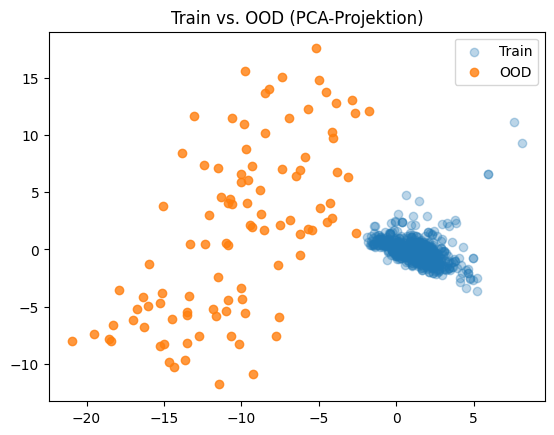

In [87]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
Z = pca.fit_transform(np.vstack([X_train, X_ood]))
plt.scatter(Z[:len(X_train), 0], Z[:len(X_train), 1], label='Train', alpha=0.3)
plt.scatter(Z[len(X_train):, 0], Z[len(X_train):, 1], label='OOD', alpha=0.8)
plt.legend(); plt.title("Train vs. OOD (PCA-Projektion)")
plt.show()

MAP Model fitting

In [13]:
# BASE NN CLASSIFIER
nn = GetNeuralNetworkClassification(len(df.columns[:-1]),len(np.unique(y)))
TrainNNClass(nn,trainLoader,epochs=200)
prob,mapentr = PredictClass(nn,tenX_OOD)
acm = accuracy_score(y_test_OOD,prob.argmax(axis=1))
print(f"Accuracy: {acm}")

Epoch: 0 | Loss: 1.11116
Epoch: 10 | Loss: 0.76333
Epoch: 20 | Loss: 0.37709
Epoch: 30 | Loss: 0.32083
Epoch: 40 | Loss: 0.19445
Epoch: 50 | Loss: 0.34481
Epoch: 60 | Loss: 0.19612
Epoch: 70 | Loss: 0.32588
Epoch: 80 | Loss: 0.22853
Epoch: 90 | Loss: 0.16360
Epoch: 100 | Loss: 0.29390
Epoch: 110 | Loss: 0.15116
Epoch: 120 | Loss: 0.03360
Epoch: 130 | Loss: 0.05020
Epoch: 140 | Loss: 0.12710
Epoch: 150 | Loss: 0.04439
Epoch: 160 | Loss: 0.06078
Epoch: 170 | Loss: 0.03377
Epoch: 180 | Loss: 0.10171
Epoch: 190 | Loss: 0.02792
Accuracy: 0.87


In [14]:
# bayesian
base = BaseNetworkCL(len(df.columns[:-1])).to(device)
head = torch.nn.Linear(in_features=4,out_features=len(df["CLASS"].unique())).to(device)
baseMod = torch.nn.Sequential(base,head)
TrainNNClass(baseMod,trainLoader,epochs=190)
# freezing base weights
for p in baseMod.parameters():
    p.requires_grad = False
acm = accuracy_score(y_test_OOD,prob.argmax(axis=1))
print(f"Accuracy: {acm}")

Epoch: 0 | Loss: 1.21952
Epoch: 10 | Loss: 0.77222
Epoch: 20 | Loss: 0.35328
Epoch: 30 | Loss: 0.34483
Epoch: 40 | Loss: 0.21025
Epoch: 50 | Loss: 0.18547
Epoch: 60 | Loss: 0.13680
Epoch: 70 | Loss: 0.13663
Epoch: 80 | Loss: 0.12688
Epoch: 90 | Loss: 0.10091
Epoch: 100 | Loss: 0.15558
Epoch: 110 | Loss: 0.25144
Epoch: 120 | Loss: 0.09262
Epoch: 130 | Loss: 0.51739
Epoch: 140 | Loss: 0.09046
Epoch: 150 | Loss: 0.16338
Epoch: 160 | Loss: 0.12342
Epoch: 170 | Loss: 0.08927
Epoch: 180 | Loss: 0.11570
Accuracy: 0.87


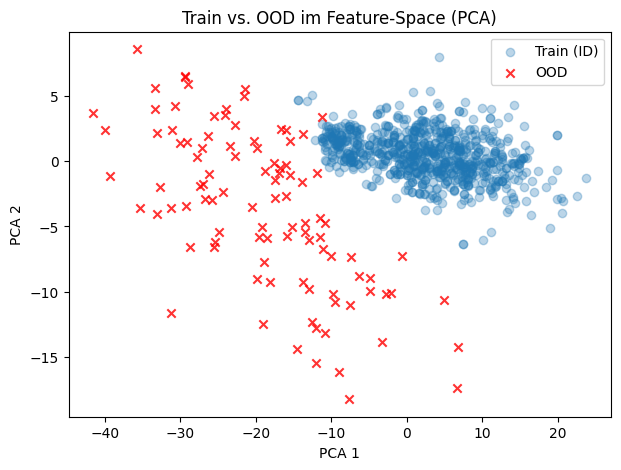

In [15]:
# Feature-Extraktion für *alle* Trainingssamples (Batchweise, falls Speicher knapp)
def get_features_tensor(base, X, device='mps', batchsize=32):
    feats = []
    base.eval()
    with torch.no_grad():
        for i in range(0, len(X), batchsize):
            xb = torch.tensor(X[i:i+batchsize], dtype=torch.float32, device=device)
            feats.append(base(xb).cpu().numpy())
    return np.vstack(feats)

# 1. Feature-Repräsentation für Training
feats_train = get_features_tensor(base, X_train, device=device)

# 2. Feature-Repräsentation für OOD
feats_ood = get_features_tensor(base, X_ood, device=device)

# 3. Gemeinsames Embedding via PCA
pca = PCA(n_components=2)
Z = pca.fit_transform(np.vstack([feats_train, feats_ood]))

# 4. Plot
plt.figure(figsize=(7,5))
plt.scatter(Z[:len(feats_train), 0], Z[:len(feats_train), 1], label='Train (ID)', alpha=0.3)
plt.scatter(Z[len(feats_train):, 0], Z[len(feats_train):, 1], label='OOD', alpha=0.8, color='red', marker='x')
plt.legend()
plt.title("Train vs. OOD im Feature-Space (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()



In [81]:
lastLayer = BayesianLastLayer(in_features=4,out_features=len(df["CLASS"].unique()),logvals=-0.5,prior_sigma=0.5).to(device)
TrainLastLayerCL(base,lastLayer,trainLoader,epochs=100)
mean_prob, entropy,exp_entr ,mi,energy = PredLastLayerCl(base,lastLayer,tenX_OOD,nSamples=110)
#accuracy
print("wLogVar:", lastLayer.wLogVar.data.mean().item())
print("bLogVar:", lastLayer.bLogVar.data.mean().item())
print("Varianz:", torch.exp(lastLayer.wLogVar.data.mean()).item())




wLogVar: -0.9742565155029297
bLogVar: -1.0828052759170532
Varianz: 0.3774728775024414


In [ ]:
# Hypeparameter
for logvals in [-6.0, -5.0, -4.0,-3.0,-2.0,-1.5,-0.5]:
    for prior_sigma in [0.1, 0.5, 1.0,1.5,2.0]:
        lastLayer = BayesianLastLayer(in_features=4,out_features=len(df["CLASS"].unique()),logvals=logvals,prior_sigma=prior_sigma).to(device)
        TrainLastLayerCL(base,lastLayer,trainLoader,class_weights=class_weights.to(device),epochs=100)
        mean_prob, entropy,exp_entr ,mi = PredLastLayerCl(base,lastLayer,tenX_OOD, nSamples=200)
        print(f"Prior Sigma: {prior_sigma}, Logvals: {logvals}")
        print("wLogVar:", lastLayer.wLogVar.data.mean().item())
        print("bLogVar:", lastLayer.bLogVar.data.mean().item())
        print("Varianz:", torch.exp(lastLayer.wLogVar.data.mean()).item())
        print(f"entropy ID:{entropy[~is_ood].mean()},entropy OOD:{entropy[is_ood].mean()}")


In [ ]:
logvals_grid    = [-3.5,-2.0,-1.0,-0.9,-0.5,-0.2]
prior_grid      = [0.5, 1.0, 2.0,2.5]
#       # dein bisheriges „kl*β“

best = None
for lv in logvals_grid:
    for ps in prior_grid:
 #       for te in t:
            last = BayesianLastLayer(4, len(df["CLASS"].unique()),
                                     logvals=lv,
                                     prior_sigma=ps).to(device)
            TrainLastLayerCL(base=base,lastLayer= last, loader=trainLoader,class_weights=class_weights.to(device),epochs=100)  # kl_weight implementieren → β*kl/N
            mean_prob, entropy,exp_entr ,mi,energy   = PredLastLayerCl(base,last,tenX_OOD ,nSamples=100)
            acc = accuracy_score(y_test_OOD,prob.argmax(axis=1))
            eid = entropy[~is_ood].mean()
            eood =entropy[is_ood].mean()
            diff = eood.mean() - eid.mean()
            print(f"lv:{lv},ps:{ps},acc:{acc}, Entropy Id:{eid}, Entropy OOD:{eood}, diff entropy: {diff}")


In [82]:
with torch.no_grad():
    feats = base(torch.tensor(X_ood[:5], dtype=torch.float32, device=device))
    outs = [lastLayer(feats).cpu().numpy() for _ in range(100)]
    outs = np.stack(outs)  # shape: (100, 5, n_classes)
    print("Logit-Std über 100 Samples:", outs.std().mean())


Logit-Std über 100 Samples: 18.818802


In [83]:
#MAP
#ID
prob_ID = prob[~is_ood]
mapentr_ID = mapentr[~is_ood]
#OOD
prob_OOD =prob[is_ood]
mapentr_OOD = mapentr[is_ood]



#BAYES
#ID
mean_prob_ID= mean_prob[~is_ood]
pred_ent_ID = entropy[~is_ood]
aleatoric_ID = exp_entr[~is_ood]
epistemic_ID = mi[~is_ood]
energy_ID = energy[is_ood]
#OOD
mean_prob_OOD= mean_prob[is_ood]
pred_ent_OOD = entropy[is_ood]
aleatoric_OOD = exp_entr[is_ood]
epistemic_OOD = mi[is_ood]
energy_OOD = energy[~is_ood]
ac = accuracy_score(y_test_OOD,mean_prob.argmax(axis=1))
print(f"ID: entropy MAP: {mapentr_ID.mean()}, BLL{pred_ent_ID.mean()} \n OOD: entropy MAP: {mapentr_OOD.mean()}, BLL { pred_ent_OOD.mean()}, \n Accuracy: {ac}, wLogvar: {lastLayer.wLogVar.mean()}")

ID: entropy MAP: 0.055041149258613586, BLL0.3049046993255615 
 OOD: entropy MAP: 0.021284498274326324, BLL 0.47970443964004517, 
 Accuracy: 0.84, wLogvar: -0.9742565155029297


PLOTS

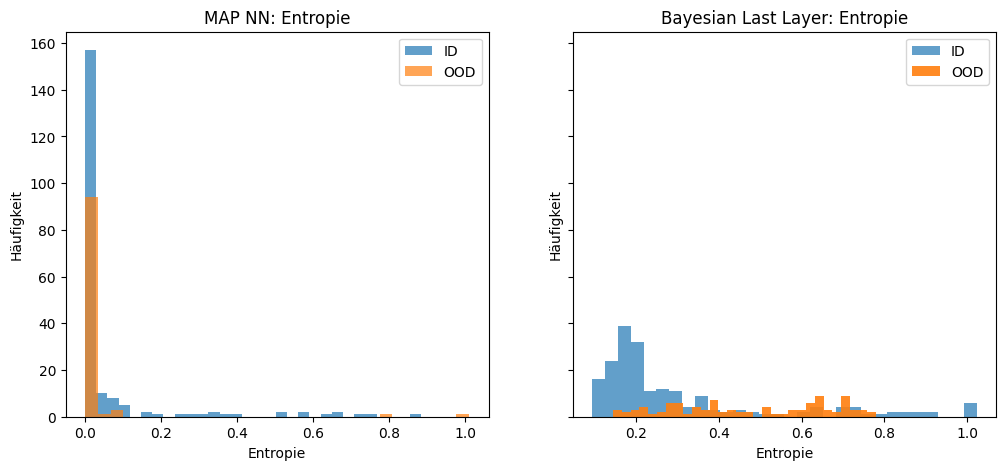

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)

#MAP ENTROPY
ax1.hist(mapentr_ID, bins=30, alpha=0.7, label='ID')
ax1.hist(mapentr_OOD, bins=30, alpha=0.7, label='OOD')
ax1.set_xlabel('Entropie')
ax1.set_ylabel('Häufigkeit')
ax1.legend()
ax1.set_title('MAP NN: Entropie')
 #BLL ENTROPY
ax2.hist(pred_ent_ID, bins=30, alpha=0.7, label='ID')
ax2.hist(pred_ent_OOD, bins=30, alpha=0.9, label='OOD')
ax2.set_title('Bayesian Last Layer: Entropie')
ax2.set_xlabel('Entropie')
ax2.set_ylabel('Häufigkeit')
ax2.legend()

plt.show()

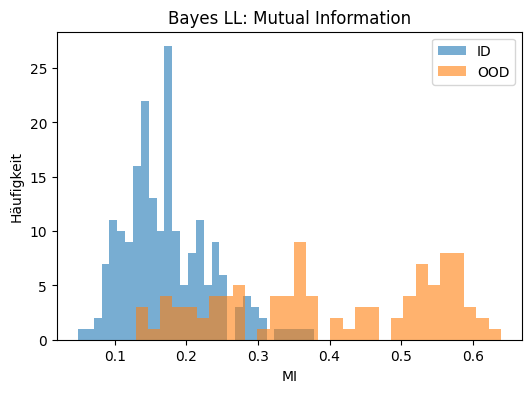

In [85]:
# Nach PredLastLayerCl:
# Plot MI statt Entropie
plt.figure(figsize=(6,4))
plt.hist(mi[~is_ood], bins=30, alpha=0.6, label="ID")
plt.hist(mi[is_ood],  bins=30, alpha=0.6, label="OOD")
plt.title("Bayes LL: Mutual Information")
plt.xlabel("MI")
plt.ylabel("Häufigkeit")
plt.legend()
plt.show()


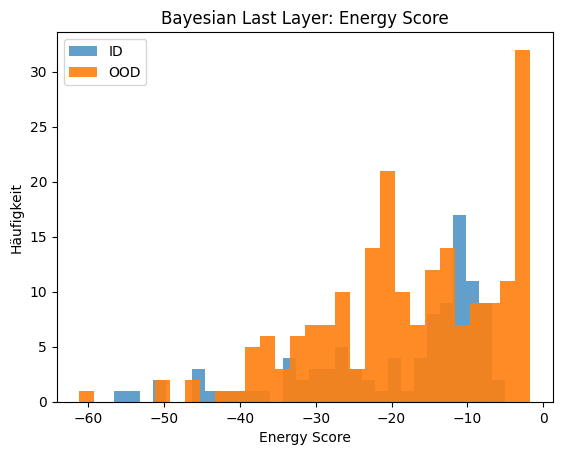

In [56]:
plt.hist(energy_ID, bins=30, alpha=0.7, label='ID')
plt.hist(energy_OOD, bins=30, alpha=0.9, label='OOD')
plt.title('Bayesian Last Layer: Energy Score')
plt.xlabel('Energy Score')
plt.ylabel('Häufigkeit')
plt.legend()
plt.show()

/var/folders/z8/f4xxfstn37ndb5_8bsvv2v2w0000gn/T/ipykernel_6589/3265223907.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


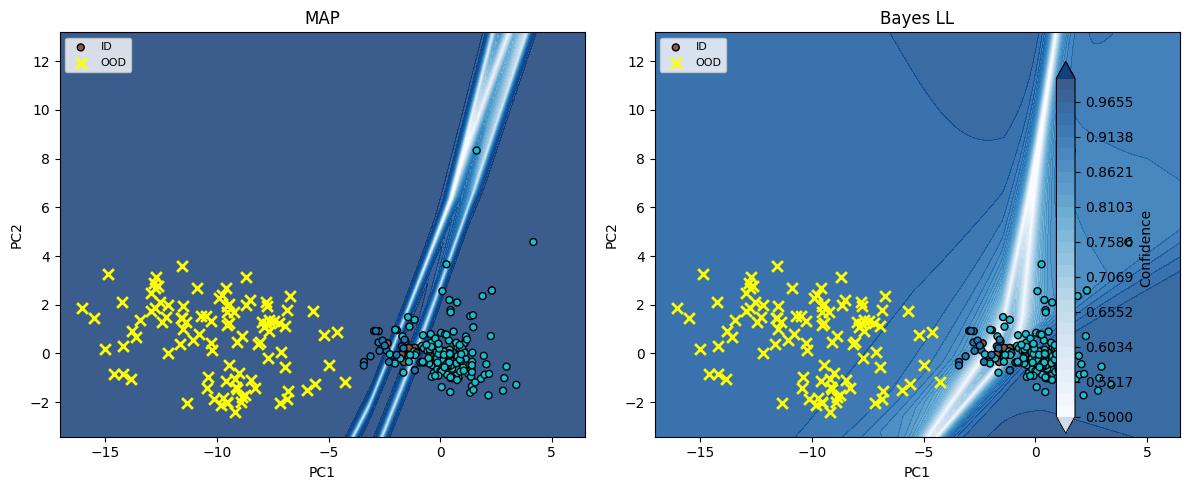

In [86]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1) PCA fitten und 2D-Embeddings berechnen
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d  = pca.transform(X_test_OOD)

# 2) Grid-Grenzen anhand aller Punkte (Train+Test) bestimmen
all_2d = np.vstack([X_train_2d, X_test_2d])
x_min, x_max = all_2d[:,0].min() - 1, all_2d[:,0].max() + 1
y_min, y_max = all_2d[:,1].min() - 1, all_2d[:,1].max() + 1

# 3) Meshgrid erzeugen
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
grid_2d   = np.c_[xx.ravel(), yy.ravel()]
grid_orig = pca.inverse_transform(grid_2d)
grid_tens = torch.tensor(grid_orig, dtype=torch.float32).to(device)

# 4) Confidence berechnen
probs_map_all, _    = PredictClass(nn,      grid_tens)
conf_map            = probs_map_all.max(axis=1)

mean_prob_bll, *_   = PredLastLayerCl(base, lastLayer, grid_tens)
conf_bll            = mean_prob_bll.max(axis=1)

# 5) Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), facecolor='white')
mappables = []

for ax, (label, conf) in zip(axes, [("MAP", conf_map), ("Bayes LL", conf_bll)]):
    m = ax.contourf(
        xx, yy, conf.reshape(xx.shape),
        levels=np.linspace(0.5, 1.0, 30),
        cmap="Blues", alpha=0.8,
        extend='both'
    )
    mappables.append(m)
    # ID-Punkte
    mask_id = ~is_ood
    ax.scatter(
        X_test_2d[mask_id, 0],
        X_test_2d[mask_id, 1],
        c=y_test_OOD[mask_id],
        cmap="tab10",
        s=25, edgecolor="k",
        label="ID"
    )
    # OOD-Punkte
    ax.scatter(
        X_test_2d[is_ood, 0],
        X_test_2d[is_ood, 1],
        marker="x", c="yellow",
        s=60, linewidths=2,
        label="OOD"
    )
    ax.set_title(label)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend(loc="upper left", fontsize=8)
    ax.set_facecolor("white")

# Gemeinsame Colorbar rechts und oberhalb aller Subplots
fig.colorbar(
    mappables[0],
    ax=axes.tolist(),
    orientation="vertical",
    fraction=0.02, pad=0.04,
    label="Confidence"
)
plt.tight_layout()
plt.show()


In [74]:
from sklearn.metrics import roc_auc_score

scores_id  = -pred_ent_ID   # tief = confident
scores_ood = -pred_ent_OOD
labels = np.concatenate([np.zeros_like(scores_id), np.ones_like(scores_ood)])
scores = np.concatenate([scores_id, scores_ood])
print("AUROC Entropy:", roc_auc_score(labels, scores))


AUROC Entropy: 0.2956
